# TTA Deep learning regression

In [28]:
%matplotlib inline

import cv2
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Model, layers, models

from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import Iterator, ImageDataGenerator

from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import Iterator, ImageDataGenerator
import tensorflow.keras.backend as K

print(tf.__version__)
print(tf.test.is_built_with_cuda()) 
print(tf.config.list_physical_devices('GPU'))

import skimage.transform

import napari

plt.style.use('ggplot')
# tf.config.gpu.set_per_process_memory_fraction(0.75)
# tf.config.gpu.set_per_process_memory_growth(True)

2.2.0
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 1. Load images and corresponding TTA

In [2]:
class ImageClassificationGenerator(Sequence):
    """
    Generates images and masks for performing data augmentation in Keras.
    We inherit from Sequence (instead of directly using the keras ImageDataGenerator)
    since we want to perform augmentation on both the input image AND the mask 
    (target). This mechanism needs to be implemented in this class. This class
    also allows to implement new augmentation transforms that are not implemented
    in the core Keras class (illumination, etc.).
    See : https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
    and https://stackoverflow.com/questions/56758592/how-to-customize-imagedatagenerator-in-order-to-modify-the-target-variable-value
    for more details.
    """

    def __init__(self, X_set, metadata, target_label="TTA", # input images and metadata containing the labels
                 n_channels_ims=1,
                 shuffle=False,
                 batch_size: int=64, dim: tuple=(32, 32),
                 n_channels: int=1, # informations 
                 normalize=True, reshape=False, crop=None, # preprocessing params
                 restrict_to="", augmentation_params=None): # data augmentation params
        """
        X_set (list, array or str): pointer to the images (Bright-Field). If str, the string is assumed to be pointing at some directory.
        metadata (pd.DataFrame): DF containing any metadata, with the targets and the file_names
        target_label (str): name of the column containing the target in the metadata dataframe
        batch_size (int): size of the batch
        dim (tuple): dimension of the images
        n_channels (int) : number of channels of the images (1 for TIF)
        shuffle (bool): Shuffle the dataset between each training epoch
        normalize (bool): normalize the images and masks in the beginning
        reshape (bool): reshape the images and masks to (dim, dim, n_channels)
        histogram_equalization (bool): perform histogram equalization to improve
        rendering using opencv
        horiz_flip_percent ()
        vert_flip_percent
        """
        # super().__init__(n, batch_size, shuffle, seed)
        self.dim = dim
        self.im_size = dim
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.n_channels_ims = n_channels_ims
        self.shuffle = shuffle
        
        self.restrict_to = restrict_to

        # build the X_set in an array. If X_set is a directory containing images
        # then self.X_set doesn't contains the images but the file names, but it
        # is transparent for the user.
        if type(X_set) == list:
            self.from_directory_X = False
            self.X_set = np.array(X_set)
        elif type(X_set) == np.array:
            self.from_directory_X = False
            self.X_set = X_set           
        elif type(X_set) == str: # assuming a path
            self.from_directory_X = True
            self.X_dir = X_set # path to the images dir
            self.X_set = []
            if self.restrict_to == "":
                for k in range(0, len(os.listdir(X_set)), self.n_channels_ims):
                    self.X_set.append(np.array(os.listdir(X_set)[k:k+self.n_channels_ims]))
                self.X_set = np.array(self.X_set)
            else:
                for k in range(0, len(os.listdir(X_set)), self.n_channels_ims):
                    if os.listdir(X_set)[k].startswith(self.restrict_to):
                        self.X_set.append(np.array(os.listdir(X_set)[k:k+self.n_channels_ims]))
                self.X_set = np.array(self.X_set)
        else:
            raise TypeError("X_set should be list, array or path")

        # Preprocessing parameters
        self.normalize = normalize
        
        # CLassification
        self.metadata = metadata
        self.target_label = target_label
        
        # The Keras generator that will be used to perform data augmentation 
        self.augmentation_params = augmentation_params
        if self.augmentation_params is not None:
            self.generator = ImageDataGenerator(**self.augmentation_params)

        # Initialize the indices (shuffle if asked)
        self.on_epoch_end()

    def __len__(self) -> int:
        """
        Number of batches per epoch : we evenly split the train set into samples
        of size batch_size.
        """
        return int(np.floor(self.X_set.shape[0] / self.batch_size))

    def __getitem__(self, index: int):
        """
        Generate one batch of data.
        """
        if index >= self.__len__():
            raise IndexError
            
        # Generate indices corresponding to the images in the batch
        indices = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Generate the batch
        X = self.__data_generation(indices)
        return X
    
    def get_image_idx(self, im_name):
        """
        Used to sort the images by an idx, when they are not properly sorted (e.g. when images
        are numbered 1 to 1000 instead of 0001 to 1000). We assume that the numerical index
        is in the form "XXX_tnumericalindex.tiff" where XXC can be anything.
        """
        if "-" in im_name.split(".")[0].split("_")[-1][1:]:
            return int(im_name.split(".")[0].split("_")[-1][1:].split("-")[-1][1:])
        else:
            return int(im_name.split(".")[0].split("_")[-1][1:])
        

    def on_epoch_end(self):
        """
        Updates indexes after each epoch. self.indexes is used to retrieve the
        samples and organize them into batches.
        If shuffle : randomizes the order of the samples in order to give 
        different training batches at each epoch.
        """
        self.indexes = np.arange(self.X_set.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs: [int]):
        """
        Generates data containing batch_size samples. This is where we load the
        images if they are in a directory, and apply transformations to them.
        """ 
        # Load data (from directory or from X_set depending on the given data)
        if self.from_directory_X:
            batch_X = []
            for im in list_IDs:
                channels = []
                for k in range(self.n_channels_ims):  # in case of several channels per image
                    channels.append(np.expand_dims(imageio.imread(f"{self.X_dir}/{self.X_set[im, k]}"), axis=-1)) # add channel axis
                batch_X.append(np.concatenate(channels, axis=-1))
            batch_X = np.array(batch_X)            
        else:
            batch_X = self.X_set[list_IDs]
        
        # generate labels from the metadata dataframe
        batch_Y = []
        for im in list_IDs:
            label = self.metadata[self.metadata["File_name"] == self.X_set[im][0].strip(".tif")][self.target_label].values[0]
            batch_Y.append(label)
        batch_Y = np.array(batch_Y)
        
        # preprocessing
        if self.normalize:
            batch_X = self.perf_normalize(batch_X)
            
        # Perform the SAME transformation on the image and on the mask
        if self.augmentation_params is not None:
            for i, img in enumerate(batch_X):
                transform_params = self.generator.get_random_transform(img.shape)
                batch_X[i] = self.generator.apply_transform(img, transform_params)

        return batch_X, batch_Y

    def perf_normalize(self, images):
        """
        Performs per image, per channel normalization by substracting the min and dividing by (max - min)
        """
        new_batch = np.empty(images.shape)
        for i, img in enumerate(images):
            assert (np.min(img, axis=(0, 1)) != np.max(img, axis=(0, 1))).all(), print("Cannot normalize an image containing only 0 or 1 valued pixels. There is likely an empty image in the training set.\nIf cropping was used,"
                                                                                       "maybe the mask doesn't contain any white pixel in the specific region.")
            new_batch[i] = (img - np.min(img, axis=(0, 1))) / (np.max(img, axis=(0, 1)) - np.min(img, axis=(0, 1)))
        return new_batch

In [3]:
# CHANGE DATASET PATH HERE
train_set_path, validation_set_path, test_set_path = "D:\Hugo\Anaphase\DL/Train_Set/", "D:\Hugo\Anaphase\DL/Validation_Set/", "D:\Hugo\Anaphase\DL/Test_Set/"
metadata = pd.read_csv("D:\Hugo\Anaphase\DL/Metadata_annotated_images_TTA_pred_DL.csv", sep=",")

restrict_to = ""
bat_size, nc_ims = 32, 1 # SPECIFY HERE THE NUMBER OF CHANNELS
target_dim, normalize = (64, 64), True
augmentation_params = augmentation_params = dict(zoom_range=[0.9, 1.2],
                           rotation_range=360,
                           height_shift_range=0.1,
                           width_shift_range=0.1,
                           fill_mode="constant", cval=0)

train_set = ImageClassificationGenerator(train_set_path, metadata[metadata["train_or_test"] == "train"], target_label="TTA", batch_size=bat_size, dim=target_dim, n_channels_ims=nc_ims, 
                         normalize=normalize, restrict_to=restrict_to, shuffle=True) #, augmentation_params=augmentation_params)

validation_set = ImageClassificationGenerator(validation_set_path, metadata[metadata["train_or_test"] == "validation"], target_label="TTA", batch_size=bat_size, dim=target_dim, n_channels_ims=nc_ims, 
                         normalize=normalize, restrict_to=restrict_to, shuffle=True)

test_set = ImageClassificationGenerator(test_set_path, metadata[metadata["train_or_test"] == "test"], target_label="TTA", batch_size=32, dim=target_dim, n_channels_ims=nc_ims, 
                         normalize=normalize, restrict_to=restrict_to, shuffle=False)

def visualize_data(bf, nc_ims=1):
    viewer = napari.Viewer()
    if nc_ims == 1:
        viewer.add_image(bf[:, :, :, :].squeeze(-1))
    else:
        viewer.add_image(bf[:, :, :, 0])  # bf
        for k in range(1, nc_ims):
            viewer.add_image(bf[:, :, :, k], blending="additive")
    napari.run()

plot = True
if plot:
    print(f"# Batches : {len(validation_set)}")
    bf, targets = train_set[0]
    print(bf.shape, targets.shape)
    visualize_data(bf, nc_ims=nc_ims)

# Batches : 36
(32, 64, 64, 1) (32,)


# 2. Train TTA Regressor

In [4]:
from tensorflow.keras.applications import VGG19

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

def get_lenet(input_shape, plot_summary=False):
    lenet = keras.Sequential()

    lenet.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    lenet.add(layers.MaxPooling2D())

    lenet.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    lenet.add(layers.MaxPooling2D())
    
    lenet.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    lenet.add(layers.MaxPooling2D())
    
    lenet.add(layers.Flatten())

#     lenet.add(layers.Dense(units=256, activation='relu'))
    
    lenet.add(layers.Dense(units=128, activation='relu'))

    lenet.add(layers.Dense(units=64, activation='relu'))
    
    lenet.add(layers.Dense(units=32, activation='relu'))

    lenet.add(layers.Dense(units=1, activation = 'linear'))
    
    if plot_summary:
        print(lenet.summary())
    
    return lenet

def get_VGG16(input_shape, plot_summary=False):    
    model = keras.Sequential()

    model.add(layers.Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=input_shape, activation='relu'))
    model.add(layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(1, activation='linear'))
    
    if plot_summary:
        print(model.summary())

    return model

def get_AlexNet(input_shape, plot_summary=False):
    #Instantiation
    AlexNet = Sequential()

    #1st Convolutional Layer
    AlexNet.add(Conv2D(filters=96, input_shape=input_shape, kernel_size=(11,11), strides=(4,4), padding='same'))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))
    AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

    #2nd Convolutional Layer
    AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))
    AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

    #3rd Convolutional Layer
    AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))

    #4th Convolutional Layer
    AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))

    #5th Convolutional Layer
    AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))
    AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

    #Passing it to a Fully Connected layer
    AlexNet.add(Flatten())
    # 1st Fully Connected Layer
    AlexNet.add(Dense(4096, input_shape=(32,32,3,)))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))
    # Add Dropout to prevent overfitting
    AlexNet.add(Dropout(0.4))

    #2nd Fully Connected Layer
    AlexNet.add(Dense(4096))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))
    #Add Dropout
    AlexNet.add(Dropout(0.4))

    #3rd Fully Connected Layer
    AlexNet.add(Dense(1000))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))
    #Add Dropout
    AlexNet.add(Dropout(0.4))

    #Output Layer
    AlexNet.add(Dense(1))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('linear'))

    #Model Summary
    if plot_summary:
        print(AlexNet.summary())
        
    return AlexNet

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 16, 16, 96)        11712     
_________________________________________________________________
batch_normalization_45 (Batc (None, 16, 16, 96)        384       
_________________________________________________________________
activation_45 (Activation)   (None, 16, 16, 96)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 8, 8, 96)          0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 8, 8, 256)         614656    
_________________________________________________________________
batch_normalization_46 (Batc (None, 8, 8, 256)         1024      
_________________________________________________________________
activation_46 (Activation)   (None, 8, 8, 256)        

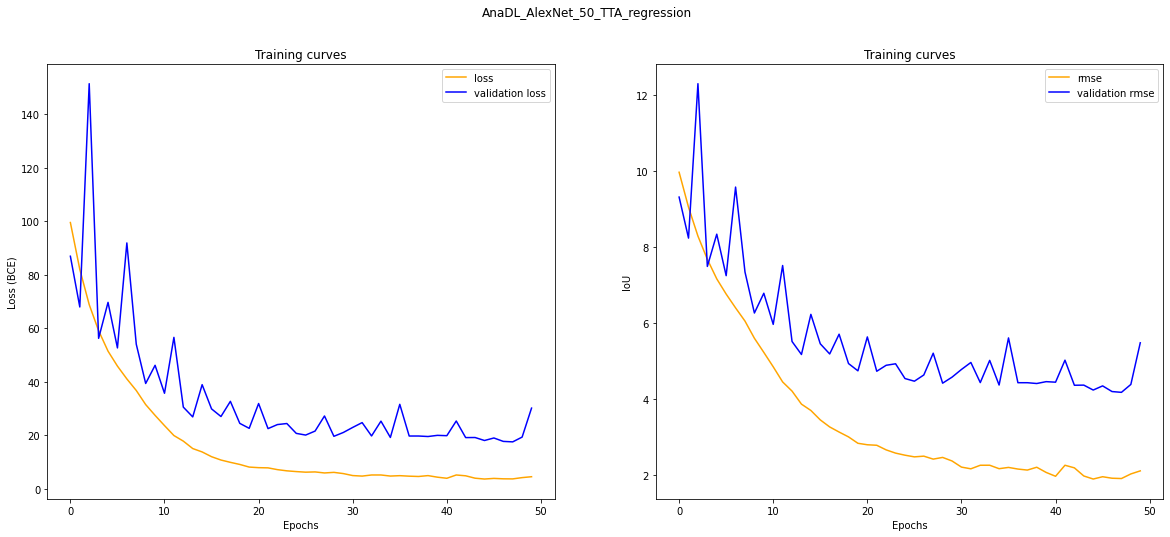

In [10]:
callbacks = keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.5, verbose=1, patience=25, min_lr=1e-5)
init_lr, n_epochs = 0.005, 50

fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# tta_classifier = get_lenet((target_dim[0], target_dim[1], nc_ims), plot_summary=True)
# tta_classifier = get_VGG16((target_dim[0], target_dim[1], nc_ims), plot_summary=True)
tta_classifier = get_AlexNet((target_dim[0], target_dim[1], nc_ims), plot_summary=True)

tta_classifier.compile(
    optimizer=keras.optimizers.Adam(learning_rate=init_lr),
    loss="mse",
    metrics=["mse", "mae"],
)

history = tta_classifier.fit(train_set, validation_data=validation_set, 
                             epochs=n_epochs, verbose=1, callbacks=callbacks)

# plot learning curves
ax[0].plot(history.history["loss"][:], "orange", label="loss")
ax[0].plot(history.history["val_loss"][:], "b", label="validation loss")
ax[0].legend()
ax[0].set_title("Training curves")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel(f"Loss (BCE)")

ax[1].plot(np.sqrt(history.history["mse"][:]), "orange", label="rmse")
ax[1].plot(np.sqrt(history.history["val_mse"][:]), "b", label="validation rmse")
ax[1].legend()
ax[1].set_title("Training curves")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("IoU")

# save model
save_path = f"D:\Hugo\Anaphase\DL/Models/"
model_name = f"AnaDL_AlexNet_{n_epochs}_TTA_regression"

fig.suptitle(model_name)

tta_classifier.save(f"{save_path}/{model_name}")

plt.savefig(f"{save_path}/{model_name}/learning_curve.png")

list_training_imgs = "\n".join(os.listdir(train_set.X_dir))

with open(f"{save_path}/{model_name}/history.txt", "w") as hist_file:
    hist_file.write(f"Model {model_name} trained for {n_epochs} epochs."
                    f"\n\nNumber of training images : {len(train_set) * bat_size}, from directory {train_set.X_dir}"
                    f"\n\nNumber of validation images : {len(validation_set) * bat_size}"
                    f"\n\nLoss : MSE"
                    f"\n\nInitial learning rate: {init_lr}."
                    f"\n\nList of the training images:\n{list_training_imgs}."
                   )

# 3. TTA classifier evaluation

No handles with labels found to put in legend.
No handles with labels found to put in legend.


RMSE on evaluation set = 5.426251395228141 min.


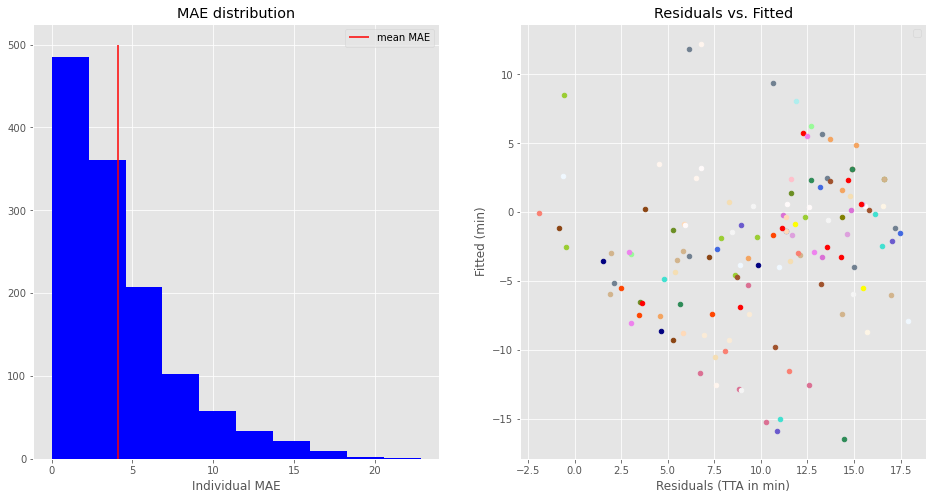

In [58]:
from sklearn.metrics import mean_squared_error

gt, predictions = [], []
for batch in test_set:
    ims, labels = batch
    preds = np.squeeze(tta_classifier.predict(ims), axis=-1)
    predictions.extend([p for p in preds])
    gt.extend([g for g in labels])
    
gt, predictions = np.array(gt), np.array(predictions)
rmse = np.sqrt(mean_squared_error(gt, predictions))
    
print(f"RMSE on evaluation set = {rmse.mean()} min.")


# plot MAE distribution
import matplotlib.colors as mcolors
by_hsv = [(tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in mcolors.CSS4_COLORS.items()]
names = [name for hsv, name in by_hsv]

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

ax = axes[0]
ax.hist(np.sqrt((gt - predictions) ** 2), color="b")
ax.vlines(np.sqrt((gt - predictions) ** 2).mean(), 0, 500, color="r", label="mean MAE")
ax.legend()
ax.set_xlabel("Individual MAE")
ax.set_title("MAE distribution")


# Predictions vs. GT
ax = axes[1]
ticks = []
for p, gt, idx in zip(predictions, gt, test_set.metadata["ID"]):
    if 100 < idx and idx < 150:
#         if idx in ticks:
        ax.plot(p, gt - p, ".", c=names[idx % len(names)], ms=9)
#         else:
#             ax.plot(p, gt - p, ".", c=names[idx % len(names)], ms=9, label=idx)
# ax.plot([-10, 40], [-10, 40], "--", c="grey", label="y=x")
ax.legend()
# ax.set_xlim(-0.5, 45)
ax.set_xlabel("Residuals (TTA in min)")
ax.set_ylabel("Fitted (min)")
ax.set_title("Residuals vs. Fitted")
ax.legend()
plt.savefig("residuals_vs_fitted_static_DL.pdf", format="pdf")